In [1]:
import numpy as np
import json
import pandas as pd
from scipy import stats


In [49]:
grade_mapping = {
    'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7,
    'C+': 2.3, 'C': 2.0, 'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'F1': 0.0, 'F2': 0.0, 'F': 0.0, 'Pass': np.nan, 'S': np.nan
}

In [50]:
with open('4_Student_Data.json', 'r') as file:
    data = json.load(file)

def convert_grade(grade):
    return grade_mapping[grade]

all_grades = []

for student_key, student_data in data.items():
    for year in student_data['academic_years']:
        for semester in year['semesters']:
            for course in semester['courses']:
                all_grades.append({
                    'student': student_key,
                    'year': year['year'],
                    'course': course['code'],
                    'semester': semester['name'],
                    'letter_grade': course['grade'],
                    'numerical_grade': convert_grade(course['grade']),
                })

df = pd.DataFrame(all_grades)

print(df.head())

    student       year  course       semester letter_grade  numerical_grade
0  Student1  2020-2021  ORY100  Fall Semester            A              4.0
1  Student1  2020-2021  BİL101  Fall Semester           B+              3.3
2  Student1  2020-2021  BİL105  Fall Semester            B              3.0
3  Student1  2020-2021  BİL110  Fall Semester           B+              3.3
4  Student1  2020-2021  ENG199  Fall Semester            A              4.0


In [51]:
print(df['numerical_grade'].describe())

print(df['letter_grade'].value_counts())

print(df.groupby('course')['numerical_grade'].mean().sort_values(ascending=False))

count    214.000000
mean       2.926168
std        0.971697
min        0.000000
25%        2.300000
50%        3.000000
75%        3.700000
max        4.000000
Name: numerical_grade, dtype: float64
letter_grade
A     53
B+    26
B     25
B-    25
A-    21
C+    19
C-    13
C     12
D+     8
D      8
F1     3
F2     1
S      1
Name: count, dtype: int64
course
BİL400     4.000000
BİL300     4.000000
ORY100     4.000000
GSBHSH     4.000000
BİL494     4.000000
BİL395     4.000000
BİL493     3.925000
GSB105     3.850000
BİL396     3.700000
ENG199     3.675000
TÜRK102    3.675000
ENG200     3.675000
ENG330     3.575000
BİL101     3.575000
BİL332     3.520000
BİL265     3.425000
FİZ105     3.425000
TÜRK101    3.400000
BİL458     3.333333
BİL456     3.333333
BİL477     3.300000
SOS203     3.250000
BİL387     3.233333
BİL172     3.150000
BİL481     3.150000
FİZ103     3.100000
ENG460     3.100000
ATA202     3.075000
BİL429     3.025000
MAT151     3.000000
BİL105     3.000000
MAT210     2.975000

Calculate The Distribution For Each Course

In [52]:

def course_stats(grades):
    #grades = grades.dropna() # Remove any Nan values although we dont have any :)
    stats =pd.Series({'count': len(grades), 'mean': grades.mean(), 'std': grades.std(ddof=1) if len(grades) > 1 else np.nan, 'df': len(grades) - 1})
    return pd.DataFrame(stats).transpose()
    


course_distributions = df.groupby('course')['numerical_grade'].apply(course_stats).reset_index()
course_distributions = course_distributions.drop('level_1', axis=1)

course_distributions.columns = ['course', 'count', 'mean', 'std', 'df']

course_distributions = course_distributions.sort_values('count', ascending=False)

pd.set_option('display.max_rows', None)  # To show all rows
print("\nFull course distributions:")
print(course_distributions)


Full course distributions:
     course  count      mean       std   df
54   MAT311    5.0  1.860000  1.446720  4.0
50   MAT152    5.0  1.280000  0.804363  4.0
17   BİL343    5.0  2.080000  1.355360  4.0
16   BİL332    5.0  3.520000  0.746324  4.0
0    ATA201    4.0  2.400000  0.424264  3.0
42   FİZ103    4.0  3.100000  0.920145  3.0
1    ATA202    4.0  3.075000  0.287228  3.0
35   BİL482    4.0  2.600000  0.424264  3.0
36   BİL493    4.0  3.925000  0.150000  3.0
37   BİL494    4.0  4.000000  0.000000  3.0
38   ENG199    4.0  3.675000  0.471699  3.0
39   ENG200    4.0  3.675000  0.471699  3.0
40   ENG330    4.0  3.575000  0.505800  3.0
41   ENG460    4.0  3.100000  1.023067  3.0
44   FİZ105    4.0  3.425000  0.960469  3.0
43   FİZ104    4.0  2.675000  0.471699  3.0
27   BİL400    4.0  4.000000  0.000000  3.0
45   FİZ110    4.0  2.675000  0.694622  3.0
49   MAT151    4.0  3.000000  1.208305  3.0
51   MAT210    4.0  2.975000  0.830161  3.0
52   MAT250    4.0  2.425000  0.763217  3.0
53  

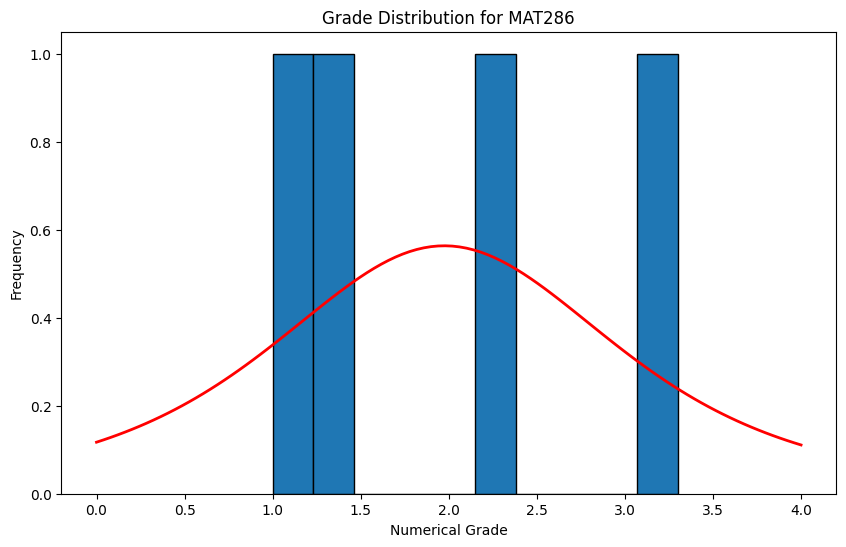

In [53]:
import matplotlib.pyplot as plt

def plot_course_distribution(df, course_code):
    course_grades = df[df['course'] == course_code]['numerical_grade'].dropna()
    if len(course_grades) < 2:
        print(f"Not enough data for course {course_code}")
        return
    
    plt.figure(figsize=(10, 6))
    plt.hist(course_grades, bins=10, edgecolor='black')
    plt.title(f'Grade Distribution for {course_code}')
    plt.xlabel('Numerical Grade')
    plt.ylabel('Frequency')
    
    # Overlay the t-distribution
    x = np.linspace(0, 4, 100)
    course_mean = course_grades.mean()
    course_std = course_grades.std(ddof=1)
    df = len(course_grades) - 1
    t_dist = stats.t.pdf(x, df, loc=course_mean, scale=course_std)
    plt.plot(x, t_dist * len(course_grades) * 0.4, 'r-', lw=2)  # Scaled for visibility
    
    plt.show()

plot_course_distribution(df,'MAT286')

In [54]:
courses_by_semester = {
    1: {"BİL101": 5, "BİL105": 2, "BİL110": 4, "ENG199": 4, "FİZ103": 2, "FİZ105": 5, "MAT151": 6, "TÜRK101": 2},
    2: {"BİL122": 5, "BİL124": 2, "BİL172": 4, "FİZ104": 2, "FİZ110": 5, "MAT152": 6, "MAT210": 4, "TÜRK102": 2},
    3: {"ATA201": 2, "BİL231": 6, "BİL265": 7, "BİL275": 7, "ENG200": 4, "SOS203": 4},
    4: {"ATA202": 2, "BİL210": 6, "BİL218": 6, "BİL240": 6, "MAT250": 5, "MAT286": 5},
    5: {"BİL300": 2, "BİL324": 5, "BİL343": 5, "BİL367": 5, "ENG330": 4, "MAT311": 5, "SOS204": 4},
    6: { "BİL332": 7, "BİL344": 7, "BİL386": 7},
    7: {"BİL493":	7, "BİL400": 3, "BİL429": 6, "ENG460": 4,},
    8: { "BİL482": 7, "BİL494":	8}
}

def numerical_to_letter_grade(grade):
    if grade >= 3.7: return 'A'
    elif grade >= 3.3: return 'A-'
    elif grade >= 3.0: return 'B+'
    elif grade >= 2.7: return 'B'
    elif grade >= 2.3: return 'B-'
    elif grade >= 2.0: return 'C+'
    elif grade >= 1.7: return 'C'
    elif grade >= 1.3: return 'C-'
    elif grade >= 1.0: return 'D+'
    elif grade >= 0.7: return 'D'
    else: return 'F'


Generating Student Data With Real Word Conditions

In [55]:
def generate_synthetic_students(course_distributions, courses_by_semester, num_students):
    all_synthetic_grades = []
    
    for _ in range(num_students):
        synthetic_grades = []
        failed_courses = []
        performance_factor = 1.0
        
        for semester, courses in courses_by_semester.items():
            semester_courses = list(courses.keys()) + failed_courses
            failed_courses = []
            
            for course in semester_courses:
                course_stats = course_distributions[course_distributions['course'] == course]
                
                if course_stats.empty:
                    print(f"Warning: No data for course {course}. Skipping.")
                    continue
                
                course_stats = course_stats.iloc[0]
                
                if course_stats['count'] > 1:
                    grade = stats.t.rvs(df=course_stats['df'], 
                                        loc=course_stats['mean'] * performance_factor, 
                                        scale=course_stats['std'])
                    grade = np.clip(grade, 0, 4)
                else:
                    grade = course_stats['mean'] * performance_factor
                    grade = np.clip(grade, 0, 4)
                
                if grade < 1.0:
                    failed_courses.append(course)
                
                grade = grade_mapping[numerical_to_letter_grade(grade)]

                synthetic_grades.append({
                    'student_id': _,
                    'semester': semester,
                    'course': course,
                    'grade': grade
                })
            
            semester_avg = np.mean([g['grade'] for g in synthetic_grades if g['semester'] == semester])
            if semester == 1 or semester == 2:
                performance_factor = (performance_factor + semester_avg / 2) / 1.5
            else:
                performance_factor = (performance_factor * 2 + semester_avg) / 3
            
            performance_factor = np.clip(performance_factor, 0.8, 1.2)
        
        all_synthetic_grades.extend(synthetic_grades)
    
    return pd.DataFrame(all_synthetic_grades)


num_students = 1000   
synthetic_df = generate_synthetic_students(course_distributions, courses_by_semester, num_students)



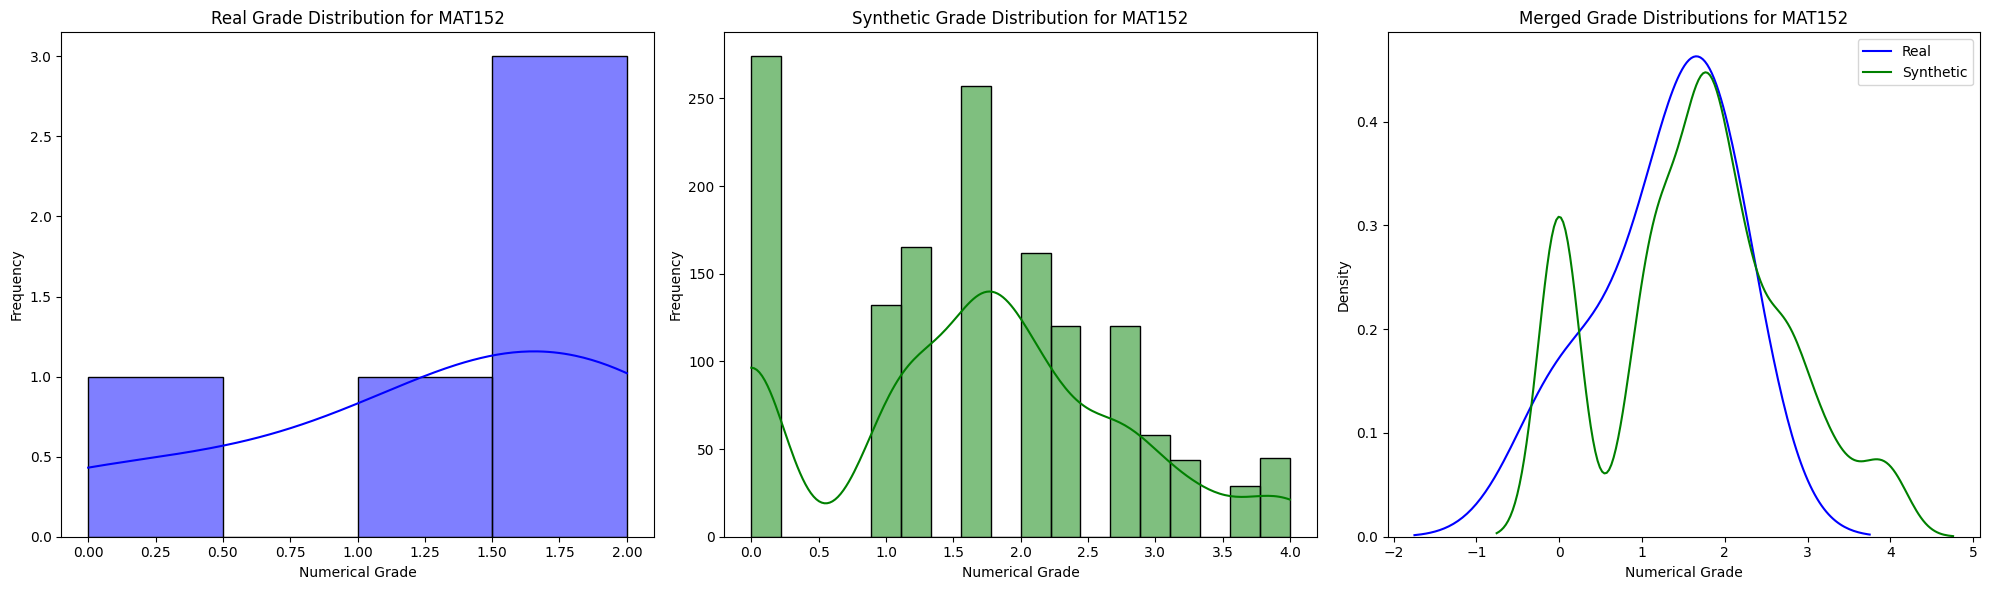

Kolmogorov-Smirnov test results for MAT152:
KS statistic: 0.2959
p-value: 0.6818


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def compare_course_distributions(real_df, synthetic_df, course_code):
    # Filter data for the specific course
    real_grades = real_df[real_df['course'] == course_code]['numerical_grade'].dropna()
    synthetic_grades = synthetic_df[synthetic_df['course'] == course_code]['grade'].dropna()
    
    if len(real_grades) < 2 or len(synthetic_grades) < 2:
        print(f"Not enough data for course {course_code}")
        return
    
    # Set up the plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot real data distribution
    sns.histplot(real_grades, kde=True, color='blue', ax=ax1)
    ax1.set_title(f'Real Grade Distribution for {course_code}')
    ax1.set_xlabel('Numerical Grade')
    ax1.set_ylabel('Frequency')
    
    # Plot synthetic data distribution
    sns.histplot(synthetic_grades, kde=True, color='green', ax=ax2)
    ax2.set_title(f'Synthetic Grade Distribution for {course_code}')
    ax2.set_xlabel('Numerical Grade')
    ax2.set_ylabel('Frequency')
    
    # Plot merged distribution
    sns.kdeplot(real_grades, color='blue', label='Real', ax=ax3)
    sns.kdeplot(synthetic_grades, color='green', label='Synthetic', ax=ax3)
    ax3.set_title(f'Merged Grade Distributions for {course_code}')
    ax3.set_xlabel('Numerical Grade')
    ax3.set_ylabel('Density')
    ax3.legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
    
    # Perform Kolmogorov-Smirnov test
    ks_statistic, p_value = stats.ks_2samp(real_grades, synthetic_grades)
    print(f"Kolmogorov-Smirnov test results for {course_code}:")
    print(f"KS statistic: {ks_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")

compare_course_distributions(df, synthetic_df, 'MAT152')

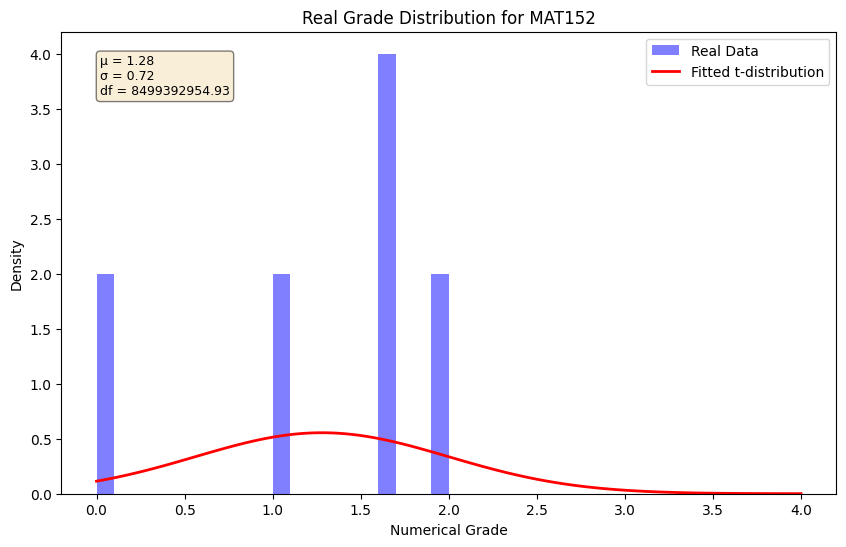

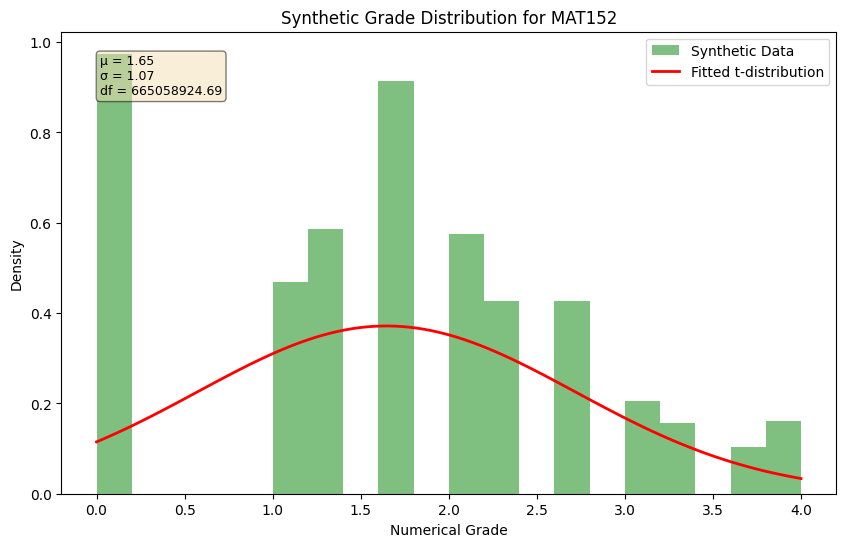

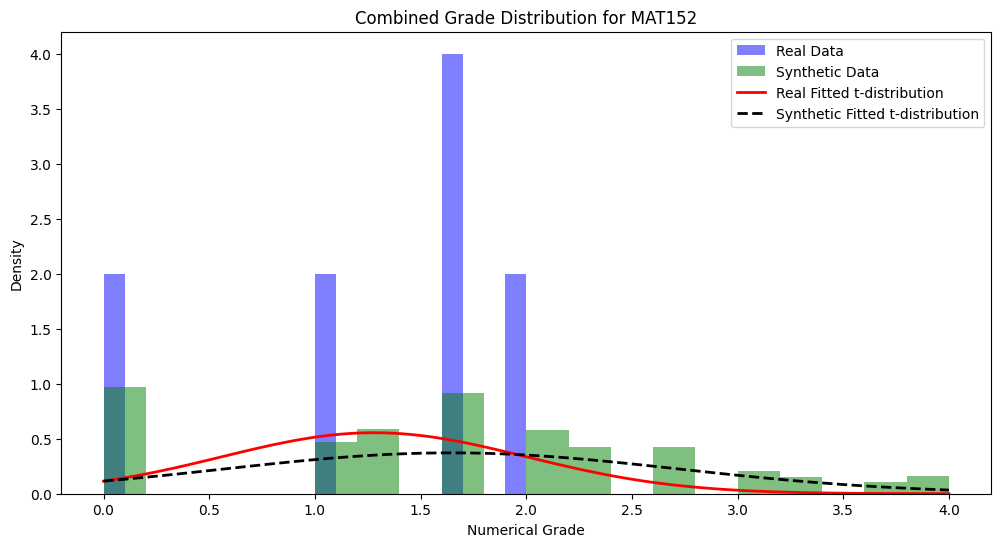

Kolmogorov-Smirnov test results for MAT152:
KS statistic: 0.2959
p-value: 0.6818


In [57]:
def plot_distribution_with_t(grades, label, course_code, color):
    plt.figure(figsize=(10, 6))
    plt.hist(grades, bins=20, alpha=0.5, color=color, label= f'{label} Data',density=True)

    df, loc, scale = stats.t.fit(grades)
  
    x = np.linspace(0, 4, 100)

    pdf = stats.t.pdf(x, df, loc=loc, scale=scale)
   
    # print(f"{label} data parameters: df = {df}, loc = {loc}, scale = {scale}")
    
    # Plot the t-distribution line
    plt.plot(x, pdf, 'r-', lw=2, label='Fitted t-distribution')
    
    plt.title(f'{label} Grade Distribution for {course_code}')
    plt.xlabel('Numerical Grade')
    plt.ylabel('Density')
    plt.legend()
    
    # Add text box with distribution parameters
    textstr = f'μ = {loc:.2f}\nσ = {scale:.2f}\ndf = {df:.2f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=9,
             verticalalignment='top', bbox=props)
    plt.show()


def plot_combined_distribution(real_grades, synthetic_grades, course_code):
    plt.figure(figsize=(12, 6))
    
    # Plot histograms
    plt.hist(real_grades, bins=20, alpha=0.5, density=True, color='blue', label='Real Data')
    plt.hist(synthetic_grades, bins=20, alpha=0.5, density=True, color='green', label='Synthetic Data')
    
    # Fit t-distributions
    real_df, real_loc, real_scale = stats.t.fit(real_grades)
    syn_df, syn_loc, syn_scale = stats.t.fit(synthetic_grades)
    
    # Create a range of x values for the t-distribution lines
    x = np.linspace(0, 4, 100)
    
    # Calculate the PDFs of the fitted t-distributions
    real_pdf = stats.t.pdf(x, real_df, real_loc, real_scale)
    syn_pdf = stats.t.pdf(x, syn_df, syn_loc, syn_scale)
    
    # Plot the t-distribution lines
    plt.plot(x, real_pdf, 'r-', lw=2, label='Real Fitted t-distribution')
    plt.plot(x, syn_pdf, 'k--', lw=2, label='Synthetic Fitted t-distribution')
    
    plt.title(f'Combined Grade Distribution for {course_code}')
    plt.xlabel('Numerical Grade')
    plt.ylabel('Density')
    plt.legend()
    
    plt.show()

def compare_course_distributions_t(real_df, synthetic_df, course_code):
    # Filter data for the specific course
    real_grades = real_df[real_df['course'] == course_code]['numerical_grade'].dropna()
    synthetic_grades = synthetic_df[synthetic_df['course'] == course_code]['grade'].dropna()
    
    if len(real_grades) < 2 or len(synthetic_grades) < 2:
        print(f"Not enough data for course {course_code}")
        return
    
    # Plot the real data distribution with a fitted t-distribution

    plot_distribution_with_t(real_grades, 'Real', course_code, 'blue')
    plot_distribution_with_t(synthetic_grades, 'Synthetic', course_code, 'green')
    plot_combined_distribution(real_grades, synthetic_grades, course_code)

    ks_statistic, p_value = stats.ks_2samp(real_grades, synthetic_grades)
    print(f"Kolmogorov-Smirnov test results for {course_code}:")
    print(f"KS statistic: {ks_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")

compare_course_distributions_t(df, synthetic_df, 'MAT152')

Cumulative Distribution Functions

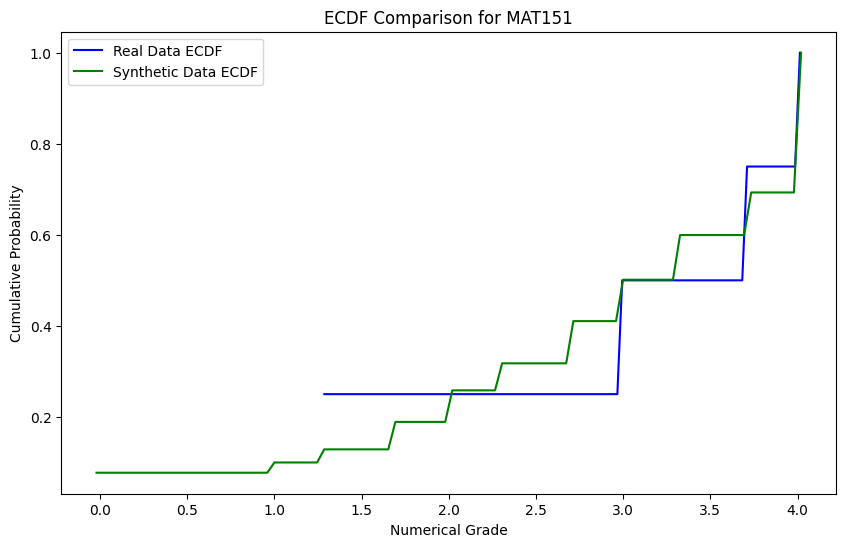

In [58]:
def plot_ecdfs(real_grades, synthetic_grades, course_code):
    plt.figure(figsize=(10, 6))

    # Compute ECDF for real data
    ecdf_real = stats.cumfreq(real_grades, numbins=100)
    x_real = ecdf_real.lowerlimit + np.linspace(0, ecdf_real.binsize*ecdf_real.cumcount.size, ecdf_real.cumcount.size)
    
    # Compute ECDF for synthetic data
    ecdf_synthetic = stats.cumfreq(synthetic_grades, numbins=100)
    x_synthetic = ecdf_synthetic.lowerlimit + np.linspace(0, ecdf_synthetic.binsize*ecdf_synthetic.cumcount.size, ecdf_synthetic.cumcount.size)

    # Plot ECDFs
    plt.plot(x_real, ecdf_real.cumcount / len(real_grades), label='Real Data ECDF', color='blue')
    plt.plot(x_synthetic, ecdf_synthetic.cumcount / len(synthetic_grades), label='Synthetic Data ECDF', color='green')
    
    plt.title(f'ECDF Comparison for {course_code}')
    plt.xlabel('Numerical Grade')
    plt.ylabel('Cumulative Probability')
    plt.legend()
    
    plt.show()

# Assuming df and synthetic_df are your dataframes and have been loaded correctly
real_grades = df[df['course'] == 'MAT151']['numerical_grade'].dropna()
synthetic_grades = synthetic_df[synthetic_df['course'] == 'MAT151']['grade'].dropna()

plot_ecdfs(real_grades, synthetic_grades, 'MAT151')

In [60]:
file_path = 'synthetic_data.csv'

synthetic_df.to_csv(file_path, index=False)

print(f"Synthetic data saved to {file_path}")

Synthetic data saved to synthetic_data.csv


In [ ]:
def add_temporal_features(df):
    # add semester as a column to specify when the student took the course  

    # Calculate cumulative GPA

    # Calculate grade trend (difference from previous semester's average)
    ### df['prev_semester_avg'] = df.groupby('student_id')['grade'].shift()
    ### df['grade_trend'] = df['grade'] - df['prev_semester_avg']
    # idk something like this should do

    return df

synthetic_df = add_temporal_features(synthetic_df)

In [ ]:
# add student info such as attendance rate and prior gpa

In [ ]:
# feature engineering

# moving average grade for each student (maybe take the mean of last 3 grades of the student)

# a binary feature showing if passing/failing

# course type? math, phys, verbal etc.

In [ ]:
# Data normalization